# Computer simulation of transport networks.
## Auteur: Pinglei He

## O Introduction

### O.0 Motivation
**English**:
This Jupyter notebook is a recode of a project dedicated to the TIPE project for the French National Entrance Exam of engineering schools, in preparation for the Digital Tech Year. The study focuses on the optimization of a transport network, according to the models and the optimization objectives stated below.

Simply put, we study the optimization of the performance of a transport network modeled as a non-oriented graph, with its nodes representing cites and the edges representing whether or not there is an direct route between two cities.

### O.1 Notations
$V$ : The number of cities

$P_v$: The population of city $v \in ⟦1 ... V⟧$

## I. The Model
### I.1 City distributions
According to the (empirical) [Zipf's Law](https://en.wikipedia.org/wiki/Zipf's_law), the populations count of the cities in a country follow the Zipf's distribution. That is to say, if we denote $V$ the total number of cities in a country, and $P_1 ... P_V$ the populations of single cities in the descendent order, we have: 
$$ \mathbb{E}(\frac{P_v}{P_1}) = \frac{1}{v} $$

To avoid unneccesary complexities in modeling the cities, we have chosen to omit the edge-case country shapes (such as the oblong Chile), nor do we consider differenc topologically unrelated/unconnected components of a country(such as Mainland US vs. Alaska) and we set the map to be a square-shape, with the position of the cities to distribute uniformely across the map.



## Importing modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import random as rd
import scipy
import scipy.sparse

The function below produces a 3 $\times$ V matrix, with each column vector representing a city in the form of $[population, x position, y position]$.
$$\begin{pmatrix}
pop_1 & ... & pop_v\\
x_1 & ... & x_v\\
y_1 & ... & y_v
\end{pmatrix}$$

In [3]:
def generate_cities(tot_population, num_city, map_width):
  """Returns a (3, num_city) array representing the cities.
  Each column contains [city_population, x-position, y_position]
  """
  harmonic_arr = np.array([1/v for v in range(1, num_city + 1)])
  harmonic_arr_normalized = harmonic_arr / harmonic_arr.sum()
  population_arr = (tot_population * harmonic_arr_normalized).reshape((1, num_city))
  position_arr = np.random.rand(2, num_city) * map_width
  return np.concatenate((population_arr, position_arr), axis=0)

## I.2 Transport net representation
In order to represent the edges of the graph, we use the dense representation with a boolean matrix. For the edge matrix M, M[i, j] is equal to true if and only if there is a road directly linking i with j. 

In [4]:
def initialize_roads(num_city, prop=0):
  """Returns a boolean array of shape (num_city, num_city) filled with False."""
  # randomly link cities with a probability of prop
  if prop:
    res = np.ramdom.rand(num_city, num_city) < prop
    for i in range(num_city):
      res[i, i] = True
      for j in range(i):
        res[i, j] = res[j, i]
    return res
  # if prop == 0
  res = np.zeros((num_city, num_city), dtype=bool)
  for i in range(num_city):
    res[i, i] = True
  return res

In [5]:
def plot_map(city_arr, road_matrix=None, map_width=None):
  """Plots the map of the region"""
  V = city_arr.shape[1]

  # plots the cities
  plt.scatter(city_arr[1, :], 
              city_arr[2, :], 
              s=city_arr[0, :], 
              c=np.random.rand(V,3)*0.7 + 0.3)
  
  # plots roads, if any
  if road_matrix is not None:
    connected_pairs = [(i, j) for i in range(V) for j in range(i) if road_matrix[i, j]]
    for i, j in connected_pairs:
      plt.plot([city_arr[1, i], city_arr[1, j]], 
              [city_arr[2, i], city_arr[2, j]],
              "g", linestyle="-")
    
  # add padding to the plot
  if map_width is not None:
    padding = map_width/25
    plt.xlim(0 - padding, map_width + padding)
    plt.ylim(0 - padding, map_width + padding)

  # set x and y axis to be equal shape
  plt.gca().set_aspect('equal', adjustable='box')

  plt.show()

Let's visualize a randomly generated map:

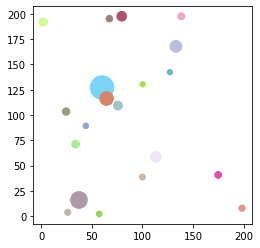

In [6]:
# seeds numpy.random for consistency
np.random.seed(60)

# params
tot_population = 2000
num_city = 20
map_width = 200

# generate a random city
city_arr = generate_cities(tot_population, num_city, map_width)

plot_map(city_arr)

If we compare the map of France to a randomly generated map using the above-mentioned method, we can see that our model produces maps that are quite similar to actual maps:

#### The population distribution of France
<img src="./images/france_city_distribution.png" alt="french_city_distribution" width="60% vw">

#### A randomly generated population distribution
<img src="./images/zipf_generated_distribution.png" alt="simulated_distribution" width="40% vw">

## II Optimization objectives
Before carrying out optimizations, we shall defined the optimization objectives. 

We assume that the probability that one person leaves his city is independent with respect to the city. We thus natually have that, the outgoing flow of population of a given city is proportional to the size of the city:
$$flow_{out}(v) \propto pop_v$$

And when it comes to ingoing population, the more population a city has, the more businesses it has, and the more attractive it is. We may assume that the ingoing population flow is somewhat proportional to its total population. :
$$ flow_{in}(v) \propto pop_v$$

If we ignoge the change in total population of the country, the above two proportionality constants must be equal.
$$ flow_{in}(v) = flow_{out}(v)$$

In this model, we assume that the relative geometrical distance between two cities does not affect the flow of population between the twto cities:

$$ flow(i, j) \propto pop_{i} \times pop_{j} $$

Since we're modeling the network as a weighted graph, let's define the weights of the edges:

if $M[i,j]$ :   $w(i,j) = d(i, j)$

if $not M[i,j]$ : $w(i,j) = \sigma \times d(i, j)$

The weight of an edge between two nodes (i,j) is defined as the cost for one unit of population to go from city i to city j (and vice versa). If there is a road between the two, we set it to be the geometric distance between the two cities. If there isn't one, we penalize the travel cost by multiply the distance with a smoothing constant $\sigma >> 1$to avoid infinities (which would be problematic for optimizations). Let's say that between two cities, there is no direct road. We suppose that traveling between the two cities would be sigma times more difficult than if there was a road (instead of considering that such a scenario is impossible).

The following equations should be pretty natual and straight-forward:

The weight of a path:
$$ w(v_1, v_2 ... v_p) = \sum_{k=1}^{p-1}w(v_k, v_k+1) $$

The distance by road (or graph distance) between two cities:
$$ \delta(i,j) = min_{\text{path between i and j}}(w(path))$$

The optimization objective to minimize is the total cost of transportation for the whole region/country:
$$ cost(M) = \sum_{1 < i, j < V} \delta(i,j) \times flow(i, j)$$

### Graph distance calculation
In order to calculate the $\delta(i,j)$s, we use the Floyd-Warshall algorithm. Since one floyd-warshall takes $O(n^3)$ to run, in order to take advantage of the multiprocessing power of the computer and the speed of a lower-level implementation, we will use the scipy module to do the Floyd-Warshall calculation.

In [7]:

def distance_matrix(city_arr):
  """Returns a matrix representing the geometric distances between cities"""
  V = city_arr.shape[1]
  res = np.zeros((V, V))

  # compute the distance between 
  def get_distance(i, j):
    dx = city_arr[1, i] - city_arr[1, j]
    dy = city_arr[2, i] - city_arr[2, j]
    return np.sqrt(dx * dx + dy * dy)

  for i in range(V):
    res[i, i] = 0
    for j in range(i):
      d_ij = get_distance(i, j)
      res[i, j] = d_ij
      res[j, i] = d_ij
  return res

def floyd_warshall(city_arr, road_matrix, sigma=10):
  """Returns a matrix distances the same dimensions as the road_matrix, where
  distances[i,j] = the cost of the shortest path between the city i and city j"""
  V = city_arr.shape[1]
  geo_distance = distance_matrix(city_arr)
  M0 = geo_distance * sigma # matrix of infinities
  M0[road_matrix] = geo_distance[road_matrix]
  return scipy.sparse.csgraph.floyd_warshall(M0, directed=False)

Now let's defined a cost function according to equations above. This function takes in input the delta_map calculated by the floyd_warshall function, and outputs the cost of the transport network. Our objective in the sections below would be to lower the cost function.

In [8]:
def get_pop_flow(city_arr):
  """Returns a matrix pop_flow where pop_flow[i, j] is the product of 
  populations of cities i and j"""
  population_arr = city_arr[[0], :]
  print(population_arr.shape)
  return population_arr * population_arr.T

In [10]:
def cost(city_arr, delta_map, pop_flow=None):
  """Returns the total cost of transportation of the network"""
  if pop_flow is None:
    pop_flow = get_pop_flow(city_arr)
  return (pop_flow * delta_map).sum() / 2

### II.3 Restructuring
The following code block simply encapsulates the code above into a TransportNetwork class, which includes information about the the network, including the positions and the populations of the cities, the map width, and the connections between them. We also added type hint for easier debugging purpopses.

In [75]:
class TransportNetwork():
    
    def __init__(self, tot_population: int, num_city: int, map_width=100, cities=None):
        self.tot_population = tot_population
        self.num_city = num_city
        self.map_width = map_width
        self.cities =  self.generate_cities() if cities is None else cities
        self.pop_flow = self.get_pop_flow()
        self.roads = self.initialize_roads()
        self.distance_matrix = self.get_distance_matrix()
        self.shortest_path_distances = self.get_shortest_path_distances()

    def generate_copy(self) -> "TransportNetwork":
        """Generates a copy of the transport network, only with empty roads."""
        return TransportNetwork(tot_population=self.tot_population, 
                                num_city=self.num_city,
                                map_width=self.map_width,
                                cities=self.cities)
        
    def generate_cities(self) -> np.array:
        """Randomly generates information about the coordinates and the populations of thecities"""
        harmonic_arr = np.array([1/v for v in range(1, self.num_city + 1)])
        harmonic_arr_normalized = harmonic_arr / harmonic_arr.sum()
        population_arr = (self.tot_population * harmonic_arr_normalized).reshape((1, self.num_city))
        position_arr = np.random.rand(2, self.num_city) * self.map_width
        return np.concatenate((population_arr, position_arr), axis=0)

    def initialize_roads(self) -> np.array:
        """Initializes the road matrix with no roads"""
        res = np.zeros((self.num_city, self.num_city), dtype=bool)
        for i in range(self.num_city):
            res[i, i] = True
        return res

    def get_distance_matrix(self) -> np.array:
        """Returns a distance matrix M where M[i, j] represents the geometric distance between city i and j"""
        res = np.zeros((self.num_city, self.num_city))

        def get_distance(i, j):
            dx = self.cities[1, i] - self.cities[1, j]
            dy = self.cities[2, i] - self.cities[2, j]
            return np.sqrt(dx * dx + dy * dy)

        for i in range(self.num_city):
            res[i, i] = 0
            for j in range(i):
                d_ij = get_distance(i, j)
                res[i, j] = d_ij
                res[j, i] = d_ij
        return res

    def get_pop_flow(self) -> np.array:
        """Returns a matrix pop_flow where pop_flow[i, j] is the product of 
        populations of cities i and j"""
        population_arr = self.cities[[0], :]
        print(population_arr.shape)
        return population_arr * population_arr.T

    def get_shortest_path_distances(self, sigma=10.0) -> np.array:
        """Returns a matrix distances the same dimensions as the road_matrix, where
        distances[i,j] = the cost of the shortest path between the city i and city j"""
        M0 = self.distance_matrix * sigma # matrix of infinities
        M0[self.roads] = self.distance_matrix[self.roads]
        return scipy.sparse.csgraph.floyd_warshall(M0, directed=False)

    def update_shortest_path_distances(self, sigma=10) -> None:
        self.shortest_path_distances = self.get_shortest_path_distances(sigma=sigma)

    def calculate_cost(self) -> float:
        """Returns the total cost of transportation of the network"""
        return (self.pop_flow * self.shortest_path_distances).sum() / 2

    def plot_map(self) -> None:
        """Plots the map of the region"""
        V = self.num_city
        city_arr = self.cities
        road_matrix = self.roads
        map_width = self.map_width

        # plots the cities
        plt.scatter(city_arr[1, :], 
                    city_arr[2, :], 
                    s=city_arr[0, :], 
                    c=np.random.rand(V,3)*0.7 + 0.3)
  
        # plots roads, if any
        if road_matrix is not None:
            connected_pairs = [(i, j) for i in range(V) for j in range(i) if road_matrix[i, j]]
            for i, j in connected_pairs:
                plt.plot([city_arr[1, i], city_arr[1, j]], 
                        [city_arr[2, i], city_arr[2, j]],
                        "g", linestyle="-")
    
        # add padding to the plot
        if map_width is not None:
            padding = map_width/25
            plt.xlim(0 - padding, map_width + padding)
            plt.ylim(0 - padding, map_width + padding)

        # set x and y axis to be equal shape
        plt.gca().set_aspect('equal', adjustable='box')

        plt.show()
    
    def add_road(self, i: int, j: int) -> None:
        self.roads[i, j] = self.roads[j, i] = True
        self.update_shortest_path_distances()

    def remove_road(self, i: int, j: int) -> None:
        self.roads[i, j] = self.roads[j, i] = False
        self.update_shortest_path_distances()

## III Algorithms
### III.0 Naive algorithm.
Before trying out sophisticated algorithms, let's first assess the possibility of applying the naive algorithm.

The naive algorithm consists of testing all the possible networks, keep those that are respect the requirement of the total length of roads, and then choosing the one that is optimal.

The total number of possible edges is $\frac{(V-1) \times (V-1))}{2} = O(V^2)$. Since for each edge, there are two possibilities of whether there is a road or not, the total number of possible configurations is $O(2^{V^2})$. Without even taking into account the calculation of the cost function, the complexity is already exponential, thus we reject the naive algorithm.



### III.2.a Greedy Algorithm
The greedy algorithm runs as follows:
We start with a graph with no roads constructed. While the total length of roads we have constructed is less than the allowed length, we test out all the possible roads that may be constructed, and choose the one that contributes the most to decreasing the cost function.

In [76]:
def greedy_algorithm(transport_network: TransportNetwork, max_road_length: float, verbose=True):
  curr_road_length = 0
  step_count = 0
  cache = {}
  
  curr_cost = transport_network.calculate_cost()

  if verbose:
    print(f"Step 0: The initial cost is {curr_cost}")


  while True: # breaks if adding any more road makes total road length reach the max allowed

    step_count += 1
    curr_best_road = None
    curr_best_cost = np.inf

    for i in range(transport_network.num_city):
      for j in range(i):

        if transport_network.roads[i, j] or transport_network.distance_matrix[i, j] > max_road_length - curr_road_length:
          continue

        transport_network.add_road(i, j)
        new_cost = transport_network.calculate_cost()
        
        if new_cost < curr_best_cost:
          curr_best_cost, curr_best_road = new_cost, (i, j)
        transport_network.remove_road(i,j)
    
    if curr_best_road is None: # no new road found
      print(f"The algorithm finished at step {step_count}")
      print(f"The cost obtained is {curr_cost}")
      break
    
    curr_cost = curr_best_cost
    i, j = curr_best_road
    transport_network.add_road(i, j)
    curr_road_length += transport_network.distance_matrix[i, j]
    if verbose:
      print(f"Step {step_count}: The current cost is {curr_best_cost}")
  
  cache["cost"] = curr_cost

Let's plot the cities to see what out test exeample looks like.

(1, 30)


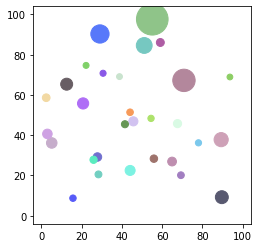

In [95]:
"""
total population: 800
number of cities: 30
allowed road length: 100000
map width: 100
"""
np.random.seed(3) # for consistency
transport_network_test = TransportNetwork(tot_population=4000, num_city=30)
transport_network_test.plot_map()

Side note:
The total oppulation doesn't actually change the output, since all operation are liner.

Let's create a network with the greedy algorithm.

In [96]:
transport_network_test_1 = transport_network_test.generate_copy()
greedy_algorithm(transport_network_test_1, max_road_length=800, verbose=True)

(1, 30)
Step 0: The initial cost is 3597877462.1525
Step 1: The current cost is 2981198747.4625177
Step 2: The current cost is 2619179611.6833367
Step 3: The current cost is 2273638980.891385
Step 4: The current cost is 1960802274.1693933
Step 5: The current cost is 1691762483.3937821
Step 6: The current cost is 1531706112.2519474
Step 7: The current cost is 1377382246.7849102
Step 8: The current cost is 1246272600.9449055
Step 9: The current cost is 1125968315.1361244
Step 10: The current cost is 1011679300.1323774
Step 11: The current cost is 935802384.619309
Step 12: The current cost is 874570110.3948181
Step 13: The current cost is 828455535.1957718
Step 14: The current cost is 786837136.5108685
Step 15: The current cost is 752972052.9771514
Step 16: The current cost is 721955520.3027048
Step 17: The current cost is 694707413.9310703
Step 18: The current cost is 668781710.4709902
Step 19: The current cost is 641507258.051141
Step 20: The current cost is 620057986.9418797
Step 21: T

We can see that the cost is decreasing with every iteration, with means our algorithm is working. Let's visualize and analyse the result:

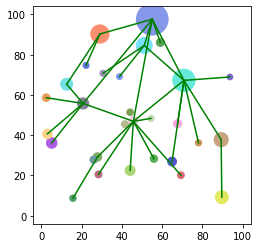

In [97]:
transport_network_test_1.plot_map()

### III.2.b Greedy algorithm II

#### Analysis of the previous algorithm
We notice a problem here: As we can see from the visualization, what our algorithm is essentially doing is linking up the smaller cities to the few bigger ones, resulting in a star-shaped (or multi-cluster star-shaped) structure. The problem is that although some roads between smaller cities have very low costs, they also contribute relatively less to decreasing the cost function. 


#### Greedy algorithm II
We can hope to solve the problem by choosing to create, at each step, not the road that decreasese the cost function the most, but the one that decreases the cost function the most **per unit of length**. We slightly adjust the greedy algorithm:

In [80]:
def greedy_algorithm_2(transport_network: TransportNetwork, max_road_length, sigma=10, verbose=True):
  curr_road_length = 0
  step_count = 0
  cache = {}
  
  curr_cost = transport_network.calculate_cost()
  if verbose:
    print(f"Step 0: The initial cost is {curr_cost}")

  while True: # breaks if no new road that satisfies curr_road_length < max_road_length is found
    step_count += 1
    curr_best_road = None
    # This line is changed:
    curr_best_cost_per_length = -np.inf
    curr_best_cost = np.inf

    for i in range(transport_network.num_city):
      for j in range(i):

        if transport_network.roads[i, j] or transport_network.distance_matrix[i, j] > max_road_length - curr_road_length:
          continue

        transport_network.add_road(i, j)
        new_cost = transport_network.calculate_cost()
        # The line below is changed:
        cost_per_length = (curr_cost - new_cost) / transport_network.distance_matrix[i, j]
        
        if cost_per_length > curr_best_cost_per_length:
          curr_best_cost_per_length, curr_best_road = cost_per_length, (i, j)
          curr_best_cost = new_cost

        transport_network.remove_road(i,j)
    
    if curr_best_road is None:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
      print(f"The algorithm finished at step {step_count}")
      print(f"The cost obtained is {curr_cost}")
      break
    
    curr_cost = curr_best_cost
    i, j = curr_best_road
    transport_network.add_road(i, j)
    curr_road_length += transport_network.distance_matrix[i, j]
    if verbose:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
    
  cache["cost"] = curr_cost

We can see that the final cost is dramatically smaller than what we get from the previous implementation. However, it took a lot more steps to train than the previous one. We may explain this by the fact that the second algorithm interests itself a lot more in connections between the neighboring smaller cities, since its goal in each step is not to find the road that has the most **per-unit-length** cost reduction. Let's have a look at the end result here:

In [99]:
transport_network_test_2= transport_network_test.generate_copy()
greedy_algorithm_2(transport_network_test_2, max_road_length=800)

(1, 30)
Step 0: The initial cost is 3597877462.1525
Step 1: The current cost is 3334766836.346578 Road length 13.623974377697039/800
Step 2: The current cost is 2890712287.372677 Road length 39.890198437676474/800
Step 3: The current cost is 2544031080.725457 Road length 61.59551551942224/800
Step 4: The current cost is 2246276150.906467 Road length 83.56652408074734/800
Step 5: The current cost is 2181276207.2942724 Road length 87.97852157934749/800
Step 6: The current cost is 2019989940.562741 Road length 102.10319884943262/800
Step 7: The current cost is 1764138145.5100813 Road length 124.82423823791135/800
Step 8: The current cost is 1518246709.3374949 Road length 148.03181847426748/800
Step 9: The current cost is 1368577001.621847 Road length 169.28663979980317/800
Step 10: The current cost is 1294927339.5035415 Road length 180.66038759889122/800
Step 11: The current cost is 1157678702.1409783 Road length 204.4103869363807/800
Step 12: The current cost is 1084787253.805427 Road le

plot_map(city_arr_test, road_matrix=road_matrix_test, map_width=map_width_test)

We can see that the cost yielded by the new algorithm is significantly smaller than that of the first greedy algorithm. Let's have a look at the new network generated by our algorithm:

The new cost is 392179815.00361025


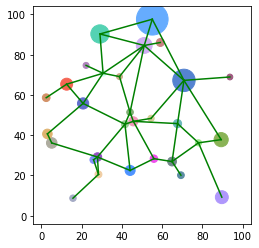

In [100]:
print(f"The new cost is {transport_network_test_2.calculate_cost()}")
transport_network_test_2.plot_map()

## III.3 Backward removal

### Context
In order to find better inspiration for the algorithms, we are going to look at a monocellular creature, called Physarum polycephalum, also commonly known as "the blob". One surprising fact about the creature is that it is a natural path finder. When given food on a flat surface, such as oatmeals for example, where each oatmeal piece is equivalent to a city, with its size proportional to the sizes of the cities, the creature can actually links between the oatmeals and produces a network which is very close to that of an optimized transportation network. More information about this creature can be found <a href="https://www.researchgate.net/figure/Comparison-of-the-Physarum-networks-with-the-Tokyo-rail-network-A-In-the-absence-of_fig2_41111573">in this paper</a>.


Below is a picture showing the blob recreating the Tokyo subway system:

<img src="./images/polysepharum_demonstration.png" width="40% vw" alt="polycepharum-reproducing-tokyo-map"/>

 We decided to buy some of polycephalum and observed the behavior of this creature. Below are images that we've taken for one week of observation.

<img src="./images/observations/day_1.png" width="30% vw" alt="day-1-observation"/>
<img src="./images/observations/day_2.png" width="30% vw" alt="day-2-observation"/>
<img src="./images/observations/day_3.png" width="30% vw" alt="day-3-observation"/>
<img src="./images/observations/day_4.png" width="30% vw" alt="day-4-observation"/>
<img src="./images/observations/day_5.png" width="30% vw" alt="day-5-observation"/>
<img src="./images/observations/day_6.png" width="30% vw" alt="day-6-observation"/>

What we observe is that the blob initially tries to create as many links as possible between the cities, as you can see from the first pictures. After having reached all the cities, the blob actually removes little by little the ones that are less used, only keeping links where the "trafic" is the most affluent, as you can see from the last two pictures.

We've decided to take inspiration directly from the blob, and instead of adding the roads little by little, we start with a dense network, where between each pair of cities there is a direct road. Then, we remove the cities little by little, until the max_road_length restriction is satisfied.

We can imagine at least one case where the backward_removal algorithm is better than the previous greedy algorithm. Let's imagine that we have three cities, with two major cities and one smaller city:

In [107]:
def backward_removal(transport_network: TransportNetwork, max_road_length: float, verbose=True, report_every=10):
  transport_network.roads = np.ones((transport_network.num_city, transport_network.num_city), dtype=bool)
  transport_network.update_shortest_path_distances()
  step_count = 0
  curr_road_length = transport_network.distance_matrix.sum() / 2
  cache = {}
  
  curr_cost = transport_network.calculate_cost()
  if verbose:
    print(f"Step 0: The initial cost is {curr_cost}")

  # We decrease incrementally the current road length
  while curr_road_length > max_road_length:
    step_count += 1
    curr_worst_road = None

    curr_worst_cost_per_length = np.inf
    curr_best_cost = np.inf

    for i in range(transport_network.num_city):
      for j in range(i):

        if not transport_network.roads[i, j]:
          continue

        transport_network.remove_road(i, j)
        new_cost = transport_network.calculate_cost()

        cost_per_length = (new_cost - curr_cost) / transport_network.distance_matrix[i, j]
        
        if cost_per_length < curr_worst_cost_per_length:
          curr_worst_cost_per_length, curr_worst_road = cost_per_length, (i, j)
          curr_best_cost = new_cost

        transport_network.add_road(i, j)
    
    if curr_worst_road is None:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
      print(f"The algorithm finished at step {step_count}")
      print(f"The cost obtained is {curr_cost}")
      break
    
    curr_cost = curr_best_cost
    i, j = curr_worst_road
    transport_network.remove_road(i, j)
    curr_road_length -= transport_network.distance_matrix[i, j]
    if verbose and step_count%report_every==0:
      print(f"Step {step_count}: The current cost is {curr_best_cost}",
            f"Road length {curr_road_length}/{max_road_length}")
    
  cache["cost"] = curr_cost

In [108]:
transport_network_test_backward_removal = transport_network_test.generate_copy()
backward_removal(transport_network_test_backward_removal, max_road_length=800, report_every=50)

(1, 30)
Step 0: The initial cost is 359787746.21525
Step 50: The current cost is 359788783.42262423 Road length 16860.175920769598/800
Step 100: The current cost is 359799393.7422343 Road length 13788.969431494419/800
Step 150: The current cost is 359832868.3901552 Road length 11150.34273031222/800
Step 200: The current cost is 359956214.1267147 Road length 8402.084759525476/800
Step 250: The current cost is 360328700.90595293 Road length 5996.445869403865/800
Step 300: The current cost is 361429507.1192944 Road length 3832.991973729272/800
Step 350: The current cost is 365800997.70097685 Road length 1909.4596777381607/800


Let's see the results:

The new cost of the backward removal algorithm is 391957296.6915276


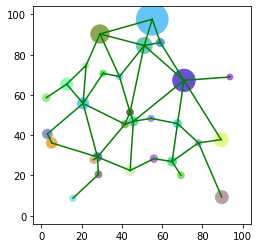

In [109]:
print(f"The new cost of the backward removal algorithm is {transport_network_test_backward_removal.calculate_cost()}")
transport_network_test_backward_removal.plot_map()

In [ ]:
def genetic_algorithm(city_arr, max_road_length, sigma=10, verbose=True, pond_size=5):
  V = city_arr.shape[1]
  road_matrix = np.ones((V, V), dtype=bool)
  pop_flow = get_pop_flow(city_arr)
  step_count = 0
  distance = distance_matrix(city_arr)
  curr_road_length = distance.sum() / 2
  cache = {}

  def add_road(i, j):
    road_matrix[i, j] = True
    road_matrix[j, i] = True
  
  def remove_road(i, j):
    road_matrix[i, j] = False
    road_matrix[j, i] = False
  
  delta_map = floyd_warshall(city_arr, road_matrix, sigma=sigma)
  curr_cost = cost(city_arr, delta_map, pop_flow=pop_flow)

ideas to try:

different sigma for training and for testing.

increase in cost / length

TODO:
complexity analysis